In [ ]:
# Import standard libraries
import os

# Third-Party Libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the Swarm Systems Lab Simulator
from ssl_simulator import SimulationEngine, load_sim, add_src_to_path
from ssl_simulator.robot_models import SingleIntegrator, Unicycle2D
from ssl_simulator.visualization import set_paper_parameters
set_paper_parameters(fontsize=15)

from ssl_simulator.components.gvf import GvfLineAB

# -------------------------------------------------------------------------------------
# Import custom functions and classes (src in path is requiered)
add_src_to_path("", deep=1)

from sim_core.visualization import PlotGvfIkCons, PlotInterpOsc, PlotGvfIkConsData
from sim_core.controllers import Oscillator, GvfIKCons

# -------------------------------------------------------------------------------------
# Define constants for file paths
OUTPUT_DIR = os.path.join("..", "..", "output")
SIMDATA_FILE = os.path.join(OUTPUT_DIR, "data.csv")

# Numerical estimation of $A(\dot{\bar x})$

In [2]:
# Define the initial state
N = 20

p = np.ones((N,2)) * np.array([[0,0]])
x0 = [p]

# Controller settings
speed = np.ones((N)) * np.array([14])
omega = np.ones((N)) * np.pi/4
A = np.linspace(0, speed[0]/omega[0]*0.999, N)

# --------------------------------
# Select and initialize the robot model and the controller
robot_model = SingleIntegrator(x0)
controller = Oscillator(A, omega, speed)

# Then, construct the Simulator Engine
dt = 0.005
simulator = SimulationEngine(robot_model, controller, time_step=dt, log_filename=SIMDATA_FILE)

# --------------------------------
# Run the simulation and save data
tf = 2*np.pi / np.min(omega) * 1.2

simulator.run(tf)
# --------------------------------

Running simulation: 100%|██████████| 1920/1920 [00:21<00:00, 87.82it/s]


In [ ]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

# Initialize the plotter with the loaded simulation data
plotter = PlotInterpOsc(simulation_data)

# Generate and display the plot
ax = plotter.plot()
plt.show()

# GVF-IK + consensus on amplitude with saturation limits

## 2 UAVs with the same speed

In [7]:
# --------------------------------
# Define the initial state

# Number of agents
N = 2

p = np.array([[10,-100], [150,150]])
speed = np.ones((N)) * np.array([14])
theta = np.ones((N)) * np.array([-np.pi/4])

x0 = [p, speed, theta]

# Conectivity graph
Z = [(i,i+1) for i in range(N-1)]

# Controller settings
omega = np.ones((N)) * 0.6
ka = 0.1

# --------------------------------
# Generate the trajectory to be followed
line_x0 = np.zeros(N)
line_y0 = np.linspace(0,60,N)
l = 2200
heading = 0

points_A = np.array([line_x0, line_y0]).T
points_B = np.array([line_x0 + l*np.cos(heading), line_y0 + l*np.sin(heading)]).T

gvf_traj = []
for i in range(N):
    gvf_traj.append(GvfLineAB(points_A[i], points_B[i]))

# Select the robot model
robot_model = Unicycle2D(x0, omega_lims=[-np.pi/4, np.pi/4])

# Initialize the controller
s, ke, kn = 1, 0.7, 1
controller = GvfIKCons(gvf_traj, Z, s, ke, kn, omega, ka)

# Then, construct the Simulator Engine
dt = 0.01
simulator = SimulationEngine(robot_model, controller, time_step=dt, 
                             log_filename=SIMDATA_FILE, log_time_step=0.5)

In [8]:
# --------------------------------
# Run the simulation and save data
tf = 120

simulator.run(tf)
# --------------------------------

Running simulation: 100%|██████████| 12000/12000 [00:05<00:00, 2059.11it/s]


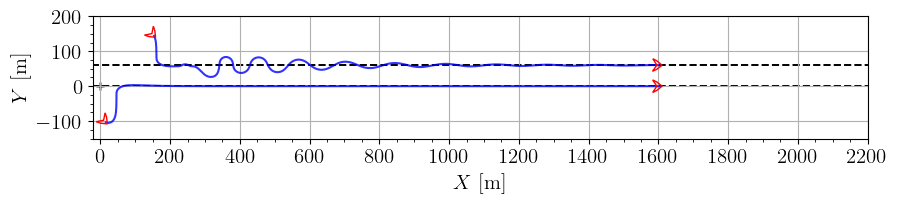

In [9]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

# Initialize the plotter with the loaded simulation data
plotter = PlotGvfIkCons(simulation_data, gvf_traj, size=30, x_step=200, y_step=100)

# Generate and display the plot
ax = plotter.plot(alpha=0.8)
ax.set_xlim([-0.01*l, l])
ax.set_ylim([-150,200])

plt.show()

## 2 UAVs with different speeds

In [ ]:
# --------------------------------
# Define the initial state

# Number of agents
N = 2

# Initial stata of the robots
p = np.array([[10,50], [120,70]])
speed = np.array([6, 7])
theta = np.zeros((N)) + 2 * (np.random.random(N) - 0.5) * np.pi/2

x0 = [p, speed, theta]

# Conectivity graph
Z = [(i,i+1) for i in range(N-1)]

# --------------------------------
# Controller settings
A = np.array([0,8,16])
omega = np.ones((N)) * np.pi/1.8
ka = 1

# --------------------------------
# Generate the trajectory to be followed
line_x0 = np.zeros(N)
line_y0 = np.linspace(0,40,N)
l = 1500
heading = 0

points_A = np.array([line_x0, line_y0]).T
points_B = np.array([line_x0 + l*np.cos(heading), line_y0 + l*np.sin(heading)]).T

gvf_traj = []
for i in range(N):
    gvf_traj.append(GvfLineAB(points_A[i], points_B[i]))

# Select the robot model
robot_model = Unicycle2D(x0)

# Initialize the controller
s, ke, kn = 1, 0.4, 1
controller = GvfIKCons(gvf_traj, Z, s, ke, kn, omega, ka)


# Then, construct the Simulator Engine
dt = 0.01
simulator = SimulationEngine(robot_model, controller, time_step=dt, log_filename=SIMDATA_FILE)
    
# --------------------------------
# Run the simulation and save data
tf = 200

simulator.run(tf)
# --------------------------------

Running simulation: 100%|██████████| 20000/20000 [00:07<00:00, 2598.68it/s]


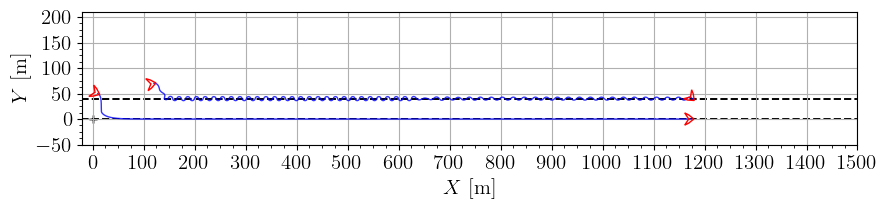

In [ ]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

# Initialize the plotter with the loaded simulation data
plotter = PlotGvfIkCons(simulation_data, gvf_traj, size=20)

# Generate and display the plot
ax = plotter.plot(alpha=0.8, lw=1)
ax.set_xlim([-20, l])
ax.set_ylim([-50,210])

plt.show()

## Multiple UAVs

In [11]:
# --------------------------------
# Define the initial state

# Number of agents
N = 8

# Initial position of the lines
line_x0 = np.zeros(N)
line_y0 = np.linspace(0,160,N)

# Initial stata of the robots
p = np.array([line_x0 + np.random.random(N)*100, line_y0 + np.random.random(N)*20]).T
p[0,1] = p[0,1] - 20 
p[-1,1] = p[-1,1] + 30 

np.random.seed(1234)
np.random.shuffle(p[:,1])

speed = np.ones((N)) * np.array([8])
theta = np.zeros((N)) + 2 * (np.random.random(N) - 0.5) * np.pi/2

# p = regpoly_formation(N,50)
# p[:,0] = p[:,0] + 35
# p[:,1] = p[:,1] + 80
# speed = np.ones((N)) * np.array([8])
# theta = np.ones((N)) * np.array([0])

x0 = [p, speed, theta]

# Conectivity graph
Z = [(i,i+1) for i in range(N-1)]

# --------------------------------
# Controller settings
omega = np.ones((N)) * 0.6
ka = 0.07

# --------------------------------
# Generate the trajectory to be followed
l = 1000
heading = 0

points_A = np.array([line_x0, line_y0]).T
points_B = np.array([line_x0 + l*np.cos(heading), line_y0 + l*np.sin(heading)]).T

gvf_traj = []
for i in range(N):
    gvf_traj.append(GvfLineAB(points_A[i], points_B[i]))

# Select the robot model
robot_model = Unicycle2D(x0, omega_lims=[-np.pi/4, np.pi/4])

# Initialize the controller
s, ke, kn = 1, 0.18, 1
controller = GvfIKCons(gvf_traj, Z, s, ke, kn, omega, ka)


# Then, construct the Simulator Engine
dt = 0.01
simulator = SimulationEngine(robot_model, controller, time_step=dt, 
                             log_filename=SIMDATA_FILE, log_time_step=0.5)

In [12]:
# --------------------------------
# Run the simulation and save data
tf = 120

simulator.run(tf)
# --------------------------------

Running simulation: 100%|██████████| 12000/12000 [00:07<00:00, 1705.33it/s]


ke = 0.18   kn = 1.00   ka = 0.07


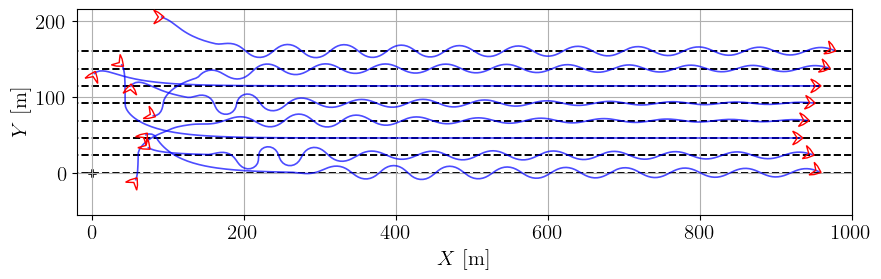

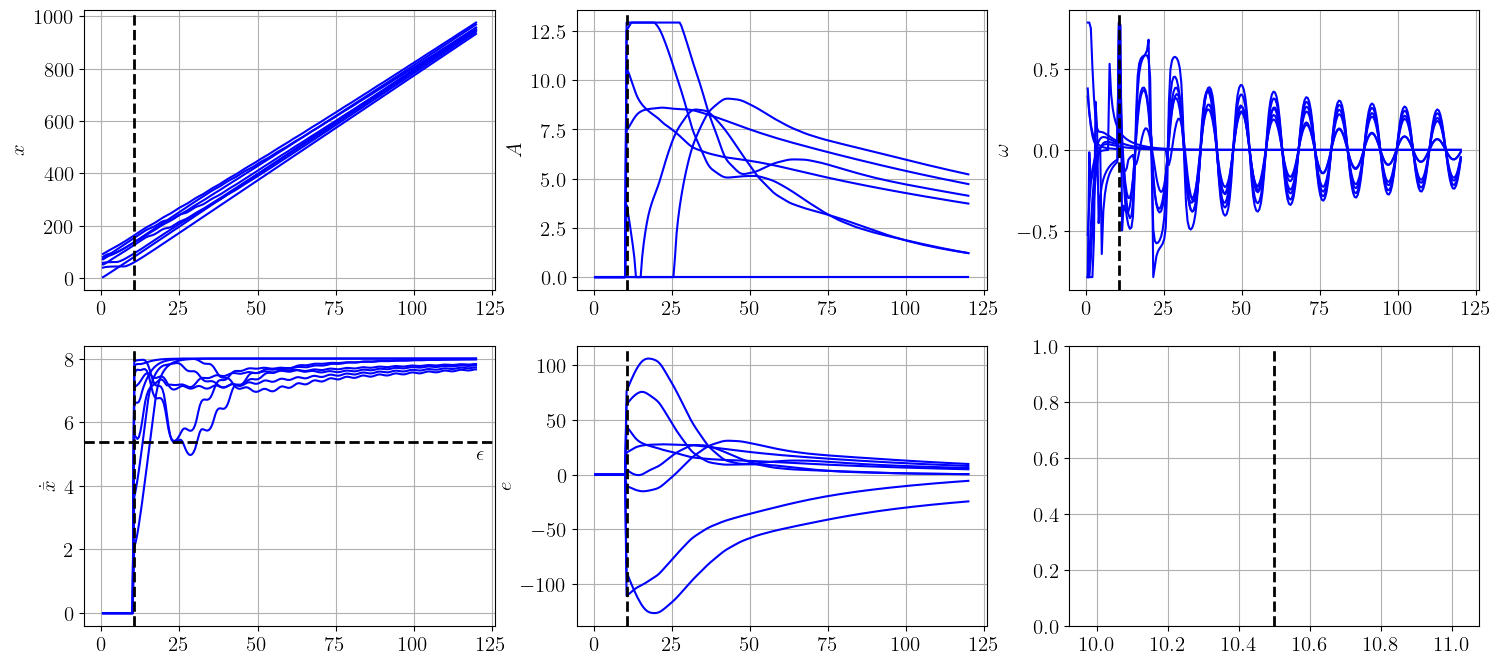

In [13]:
# Load previously saved simulation data from the specified file
simulation_data = load_sim(SIMDATA_FILE, debug=False)

# Initialize the plotter with the loaded simulation data
plotter = PlotGvfIkConsData(simulation_data, gvf_traj, size=15, lw=1)

# Generate and display the plot
ax = plotter.plot(lw=1.2, alpha=0.7)
ax.set_xlim([-20, l])
ax.set_ylim([-55,215])

plotter.plot_data()

plt.show()